#MATH80629A Project: Predicting BIXI bike usage based on historical weather data

A project by: 
* William Désilets
* Simon Drolet (11178019)
* Gabriella Bincoletto-Montpetit (11149602)

# Part 1: Data pre-processing

## 1.1. Import relevant packages

In [ ]:
# Run this line into anaconda prompt: pip install holidays
import holidays as holidays

In [1]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
#from google.colab import files
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
#from geopy import distance
#from geopy.distance import great_circle
#from shapely.geometry import MultiPoint
#from geopy.distance import vincenty
import matplotlib.cm as cm
#import dask.dataframe as dd

## 1.2. Weather Data

### 1.2.1. Import weather files

In [ ]:
# Since I have 84 files (7 years, 12 months per year) over 3 stations, I'll loop!

# This code lists the 252 weather URLs from our GitHub rep. Actually we only keep 162 because we remove Dec/Jan/Feb (No Bixis)!
weather_urls = list()
for s in [['7024745_','McTavish'],['7027329_','St-Hubert'],['7025251_','YUL']]: # McTavish, St-Hubert, YUL
    for y in range(7):
        for m in range(9):
            year = str(y + 2014)
            month = '0' + str(m+3) + '-'
            if len(month) == 4 : month = month[1:]
            url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/' + s[1] + '/fr_climat_horaires_QC_' + s[0] + month + year + '_P1H.csv'
            weather_urls.append(url)



In [ ]:
print('Take that Git!')

In [ ]:
# Let's make all these CSVs into proper Pandas
weather_dfs = list()
n = 0
for file in weather_urls:
    weather_dfs.append(pd.read_csv(file))
  
    # A lot of columns are always empty, so let's remove them before anything else!
    weather_dfs[n] = weather_dfs[n].drop(['Date/Heure (HNL)','Temp Indicateur','Point de rosée Indicateur',\
                     'Hum. rel. Indicateur','Hauteur de précip. Indicateur',\
                     'Dir. du vent Indicateur','Vit. du vent Indicateur',\
                     'Visibilité Indicateur', 'Pression à la station Indicateur',\
                     'Hmdx Indicateur','Refroid. éolien Indicateur'],axis=1)
  
    # Let's clean up the "Heure" field so it's easier to use.
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip('0')
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].str.strip(':')
    weather_dfs[n]['Heure (HNL)'].mask(weather_dfs[n]['Heure (HNL)'] == '', '0', inplace=True)
    weather_dfs[n]['Heure (HNL)'] = weather_dfs[n]['Heure (HNL)'].astype(int)

    # BIXIs are only available from March 15 to November 15. Let's remove the useless days (keeping the day before)
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 3) & (weather_dfs[n]['Jour'] < 14)].index, inplace=True) # Mars
    weather_dfs[n].drop(weather_dfs[n][(weather_dfs[n]['Mois'] == 11) & (weather_dfs[n]['Jour'] > 15)].index, inplace=True) # Novembre

    # And we convert the field "Temps" to a list and remove NAN
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].fillna('ND')
    weather_dfs[n]['Temps'] = weather_dfs[n]['Temps'].str.split(',')

    n = n + 1
    if n % 21 == 0 : print('Upload %d percent complete' % (n/189*100)) # If I change the number of years this line won't work!

### 1.2.2. Cleaning

In [ ]:
# We find all the possible weather conditions that can be identified in "Temps" to create indicative variables
# From: https://climat.meteo.gc.ca/glossary_f.html 

  # Here is the list that will be used

"""
  ND (0s everywhere)
  nan (0s everywhere)
  *
  BROUILLARD: Brume sèche OU Fumée (1), Brouillard OU Chasse-poussière élevée (2), brouillard verglaçant (3)
  PLUIE: Pluie OU Averses de pluie (1), Pluie modérée OU Averses de pluie modérée (2), Pluie forte OU Averses de pluie forte (3), Pluie verglaçante OU Averses de pluie verglaçante (4)
  BRUINE: Bruine (1), bruine verglaçante (2)
  ORAGES: Orages (1)
  NEIGE: Neige OU Averses de neige OU Neige en grains (1), Neige modérée (2), Poudrerie élevée OU Averses de granules de glace ou de grésil OU Granules de glace ou grésil OU Grêle (3) 
  SOLEIL: Généralement dégagé (1), dégagé (2)
  NUAGES: Généralement nuageux (1), nuageux (2)
"""

# NUAGES
def fnuages(row):
    if ('Généralement nuageux' in row['Temps']):
        val = 1
    elif ('Nuageux' in row['Temps']):
        val = 2
    else:
        val = 0
    return val

# SOLEIL
def fsoleil(row):
    if ('Généralement dégagé' in row['Temps']):
        val = 2
    elif ('Dégagé' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# ORAGES
def forages(row):
    if ('Orages' in row['Temps']) or ('Orage' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# NEIGE
def fneige(row):
    if ('Poudrerie élevée' in row['Temps']) or ('Grêle' in row['Temps']) or ('Granules de glace ou grésil' in row['Temps']) or ('Averses de granules de glace ou de grésil' in row['Temps']):
        val = 3
    elif ('Neige modérée' in row['Temps']):
        val = 2
    elif ('Neige' in row['Temps']) or ('Averses de neige' in row['Temps']) or ('Neige en grains' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# PLUIE
def fpluie(row):
    if ('Pluie verglaçante' in row['Temps']) or ('Averses de pluie verglaçante' in row['Temps']):
        val = 4
    elif ('Pluie forte' in row['Temps']) or ('Averses de pluie forte' in row['Temps']):
        val = 3
    elif ('Pluie modérée' in row['Temps']) or ('Averses de pluie modérées' in row['Temps']):
        val = 2
    elif ('Pluie' in row['Temps']) or ('Averses de pluie' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# BROUILLARD
def fbrouillard(row):
  if ('Brouillard verglaçant' in row['Temps']):
    val = 3
  elif ('Brouillard' in row['Temps']) or ('Chasse-poussière élevée' in row['Temps']):
    val = 2
  elif ('Brume sèche' in row['Temps']) or ('Fumée' in row['Temps']):
    val = 1
  else:
    val = 0
  return val

# BRUINE
def fbruine(row):
    if ('Bruine verglaçante' in row['Temps']):
        val = 2
    elif ('Bruine' in row['Temps']):
        val = 1
    else:
        val = 0
    return val

# Applying all the functions
for df in weather_dfs:
    df['Pluie'] = df.apply(fpluie,axis=1)
    df['Neige'] = df.apply(fneige,axis=1)
    df['Orages'] = df.apply(forages,axis=1)
    df['Bruine'] = df.apply(fbruine,axis=1)
    df['Brouillard'] = df.apply(fbrouillard,axis=1)
    df['Nuages'] = df.apply(fnuages,axis=1)
    df['Soleil'] = df.apply(fsoleil,axis=1)




In [ ]:
# We will merge all the dataframes together into one huge table to make the splitting/aggregating easier
weather_df = pd.DataFrame()
for df in weather_dfs:
    weather_df = pd.concat([weather_df, df], ignore_index=True)

In [ ]:
# Some of the column which should contain floats or int contain strings. Let's fix!
# NOTE: Only run this cell once! Else it will fail.

# First we change commas to periods in numbers
weather_df['Longitude (x)'] = (weather_df['Longitude (x)'].str.replace(',','.')).astype(float)
weather_df['Latitude (y)'] = (weather_df['Latitude (y)'].str.replace(',','.')).astype(float)
weather_df['Temp (°C)'] = (weather_df['Temp (°C)'].str.replace(',','.')).astype(float)
weather_df['Point de rosée (°C)'] = (weather_df['Point de rosée (°C)'].str.replace(',','.')).astype(float)
weather_df['Hauteur de précip. (mm)'] = (weather_df['Hauteur de précip. (mm)'].str.replace(',','.')).astype(float)
weather_df['Visibilité (km)'] = (weather_df['Visibilité (km)'].str.replace(',','.')).astype(float)
weather_df['Pression à la station (kPa)'] = (weather_df['Pression à la station (kPa)'].str.replace(',','.')).astype(float)

# I'll also change the station IDs so it's easier to use later
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7024745, 1, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7027329, 2, inplace=True)
weather_df['ID climatologique'].mask(weather_df['ID climatologique'] == 7025251, 3, inplace=True)
weather_df['stationID'] = weather_df['ID climatologique']

# Finally, we can drop the fields which we have transformed earlier
weather_df = weather_df.drop(['Temps','ID climatologique', 'Nom de la Station'], axis=1)

In [ ]:
weather_df.head()

### 1.2.3. Relevant functions

In [ ]:
# Here are some functions that will be useful later (for weighted averages)

# Distance (HAVERSINE)
def distance(lon1,lat1,lon2,lat2):
    R = 6367.5
    dlon = np.abs(np.radians(lon2) - np.radians(lon1)) 
    dlat = np.abs(np.radians(lat2) - np.radians(lat1)) 
    a = np.sin(dlat/ 2)**2 + np.cos(np.radians(lat2)) * np.cos(np.radians(lat1)) * np.sin(dlon / 2)**2
    L = R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return L

# Weigthed Average
def weighted(x, cols, w="Distance"):
    return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)

In [ ]:
# Let's write a function that allows to create a new df according to the specifications that we want!
# First we can choose what data to keep (Which year, month, day)
# Second we choose how to aggregate the data!

def create_weather_df(years=[weather_df.Année.min(),weather_df.Année.max()]\
                      , months=[weather_df.Mois.min(),weather_df.Mois.max()]\
                      , days=[weather_df.Jour.min(),weather_df.Jour.max()]\
                      , hours=[weather_df['Heure (HNL)'].min(),weather_df['Heure (HNL)'].max()]\
                      , aggType = 1 # 1 = hourly ; 2 = daily ; 3 = monthly
                      , geo = list()): # We can insert [Lon, Lat] 
  
  # Filtre temporel
    rdf = weather_df[(weather_df['Année'] >= years[0]) & (weather_df['Année'] <= years[1])]
    rdf = rdf[(rdf['Mois'] >= months[0]) & (rdf['Mois'] <= months[1])]
    rdf = rdf[(rdf['Jour'] >= days[0]) & (rdf['Jour'] <= days[1])]
    rdf = rdf[(rdf['Heure (HNL)'] >= hours[0]) & (rdf['Heure (HNL)'] <= hours[1])]

  # Creating a date ID (will vary based on type of aggregation)
    rdf.Année = rdf.Année.astype(str)
    rdf.Mois = rdf.Mois.astype(str)
    rdf.Jour = rdf.Jour.astype(str)
    rdf['Heure (HNL)'] = rdf['Heure (HNL)'].astype(str)
    rdf.loc[rdf['Mois'].str.len() == 1, 'Mois'] = '0' + rdf['Mois']
    rdf.loc[rdf['Jour'].str.len() == 1, 'Jour'] = '0' + rdf['Jour']
    rdf.loc[rdf['Heure (HNL)'].str.len() == 1, 'Heure (HNL)'] = '0' + rdf['Heure (HNL)']
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure (HNL)']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)
    
    # Return to int
    rdf['Année'] = rdf.Année.astype(int)
    rdf['Mois'] = rdf.Mois.astype(int)
    rdf['Jour'] = rdf.Jour.astype(int)
    rdf['Heure (HNL)'] = rdf['Heure (HNL)'].astype(int)
  
    if not geo: # Average across all three stations
    # Aggregate hourly data by default
        rdf = rdf.groupby('dateIDh').agg(Temp=("Temp (°C)", "mean"),
                                      DewPoint=("Point de rosée (°C)", "mean"),
                                      HumRel=("Hum. rel (%)", "mean"),
                                      PrecipitationHgt=("Hauteur de précip. (mm)", "mean"),
                                      WindDir=("Dir. du vent (10s deg)", "mean"),
                                      WindSpd=("Vit. du vent (km/h)", "mean"),
                                      Vis=("Visibilité (km)", "mean"),
                                      Pkpa=("Pression à la station (kPa)", "mean"),
                                      Hmdx=("Hmdx", "mean"),
                                      WindChill=("Refroid. éolien", "mean"),
                                      Rain=("Pluie", "max"),
                                      Snow=("Neige", "max"),
                                      Thunderstorm=("Orages", "max"),
                                      Drizzle=("Bruine", "max"),
                                      Fog=("Brouillard", "max"),
                                      Cloudy=("Nuages", "max"),
                                      Sunny=("Soleil", "max"), 
                                      dateIDd=("dateIDd","mean"), 
                                      dateIDm=("dateIDm","mean"),
                                      Year=("Année","mean"),
                                      Month=("Mois","mean"),
                                      Day=("Jour","mean"),
                                      Hour=("Heure (HNL)","mean")   
                                      )
    

    else: # When geo option is ACTIVE
        # Ajouter une colonne de distance
        rdf['Distance'] = rdf.apply(lambda x: distance(x['Longitude (x)'], x['Latitude (y)'], geo[0], geo[1]), axis=1)
        # Date IDs
        rdf_date = rdf.groupby('dateIDh').agg(dateIDd=("dateIDd","mean"), dateIDm=("dateIDm","mean"))  
        # Hourly aggregation, weighted by distance (for continuous variables) # NOTE !!!! PRECIPITATION HEIGHT AND VIS NOT WORKING I THINK
        rdf_grouped = rdf.groupby('dateIDh')
        rdf_weighted = rdf_grouped.apply(weighted,["Temp (°C)",
                                       "Point de rosée (°C)",
                                       "Hum. rel (%)",
                                       "Dir. du vent (10s deg)",
                                       "Vit. du vent (km/h)",
                                       "Pression à la station (kPa)",
                                       "Hmdx",
                                       "Refroid. éolien"])
        # We have to do it separately for the precipitation height and visibility because station 3 has all NAN fro Precipitation, and station 1 has all NAN for Visibility
        # NOTE: This is not the most elegant as it's somehow hardcoded. It means the function will fail if we get new weather stations.
        # Precipitation
        rdf_precip = rdf.loc[rdf['stationID'].isin([1,2])]
        rdf_grouped2 = rdf_precip.groupby('dateIDh')
        rdf_weighted2 = rdf_grouped2.apply(weighted,["Hauteur de précip. (mm)"])
        rdf_weighted2.rename(columns={'Hauteur de précip. (mm)':'PrecipitationHgt'}, inplace=True)
        # Visibility
        rdf_vis = rdf.loc[rdf['stationID'].isin([2,3])]
        rdf_grouped3 = rdf_vis.groupby('dateIDh')
        rdf_weighted3 = rdf_grouped3.apply(weighted,["Visibilité (km)"])
        rdf_weighted3.rename(columns={'Visibilité (km)':'Vis'}, inplace=True)
        # We rename the columns of the original big batch weighted averages
        rdf_weighted.rename(columns={'Temp (°C)':'Temp',
                                 'Point de rosée (°C)':'DewPoint',
                                 'Hum. rel (%)':'HumRel',
                                 'Dir. du vent (10s deg)':'WindDir',
                                 'Vit. du vent (km/h)':'WindSpd',
                                 'Pression à la station (kPa)':'Pkpa',
                                 'Refroid. éolien':'WindChill'}, inplace=True)
    
        # For the categorical variables, we take the value closest to the location
        rdf_min = rdf.loc[rdf['stationID'].isin([2,3])] # Pas de données texte pour la station 1!
        rdf_min = rdf_min.loc[rdf['Distance'] == rdf_min['Distance'].min()]
        rdf_min = rdf_min.set_index('dateIDh')
        rdf_min = rdf_min[['Pluie','Neige','Orages','Brouillard']]
        # Annnnnd rename again:
        rdf_min = rdf_min.rename(columns={'Pluie':'Rain',
                                     'Neige':'Snow',
                                     'Orages':'Thunderstorm',
                                     'Brouillard':'Fog'
                                      })
    
        # Finally we add the column about cloud cover and drizzle, which are only available at one station
        rdf_sun = rdf.groupby('dateIDh').agg(Drizzle=("Bruine","max"), Cloudy=("Nuages","max"), Sunny=("Soleil","max")) 

        # We concatenate all the pandas together. The resulting df has the same format has the 'non-geo' one so we can pass it to agg=2 or agg=3 easily
        rdf = pd.concat([rdf_date,rdf_weighted,rdf_weighted2,rdf_weighted3,rdf_min,rdf_sun], axis=1)
    
      
    if aggType == 2 or aggType == 3:
        # Compute daily data
        rdf.loc[rdf["PrecipitationHgt"] > 0, 'RainToday'] = 1
        rdf.loc[rdf["PrecipitationHgt"] == 0, 'RainToday'] = 0
        rdf = rdf.groupby('dateIDd').agg(avgTemp=("Temp", "mean"),
                                      maxTemp=("Temp", "max"),
                                      minTemp=("Temp", "min"),
                                      avgDewPoint=("DewPoint", "mean"),
                                      avgHumRel=("HumRel", "mean"),
                                      maxHumRel=("HumRel", "max"),
                                      minHumRel=("HumRel", "min"),
                                      sumPrecipitationHgt=("PrecipitationHgt", "sum"),
                                      timePrecipitation=("RainToday", "mean"),
                                      precipitationToday=("RainToday", "max"),
                                      avgWindDir=("WindDir", "mean"),
                                      avgWindSpd=("WindSpd", "mean"),
                                      maxWindSpd=("WindSpd", "max"),
                                      avgVis=("Vis", "mean"),
                                      avgPkpa=("Pkpa", "mean"),
                                      avgHmdx=("Hmdx", "mean"),
                                      avgWindChill=("WindChill", "mean"),
                                      maxWindChill=("WindChill", "max"),
                                      minWindChill=("WindChill", "min"),
                                      Rain=("Rain", "max"), # Qualifie l'intensité maximale des précipitations dans la journée
                                      Snow=("Snow", "max"),
                                      Thunderstorm=("Thunderstorm", "max"),
                                      Drizzle=("Drizzle", "mean"),
                                      Fog=("Fog", "mean"),
                                      percentCloudy=("Cloudy", "mean"),
                                      percentSunny=("Sunny", "mean"),
                                      dateIDm=("dateIDm","mean"),
                                      Year=("Year","mean"),
                                      Month=("Month","mean"),
                                      Day=("Day","mean")   
                                      )
      
        if aggType == 3:
        # Dans un mois les max-min ne sont plus très utiles!
            rdf = rdf.groupby('dateIDm').agg(avgTemp=("avgTemp", "mean"),
                                         avgHigh=("maxTemp", "mean"),
                                         avgLow=("minTemp", "mean"),
                                         avgHumRel=("avgHumRel", "mean"),
                                         sumPrecipitationHgt=("sumPrecipitationHgt", "sum"),
                                         avgDailyPrecipitation=("timePrecipitation", "mean"),
                                         daysRain=("precipitationToday", "sum"), 
                                         avgWindSpd=("avgWindSpd", "mean"),
                                         avgWindChill=("avgWindChill", "mean"),
                                         avgHighWindchill=("maxWindChill","mean"),
                                         avgLowWindchill=("minWindChill","mean"),
                                         percentCloudy=("percentCloudy", "mean"),
                                         percentSunny=("percentSunny", "mean"),
                                         Year=("Year","mean"),
                                         Month=("Month","mean")    
                                         )

    return rdf

### 1.2.4. Create useful weather pandas

In [ ]:
# You can then call the dataframe that you want with the "create_weater_df"
#  ****** But, adventurer, watch out: it takes much more time to generate the dataframe you want when you call the function with the GEO option. Choose wisely.
df = create_weather_df(years=[2018,2020], months=[7,11], days=[8,22], aggType=3) 
df.head()

In [ ]:
# Weather data is compiled hourly (without location)
weather_hourly = create_weather_df(aggType=1)
weather_hourly.to_csv('weather_hourly.csv') 

In [ ]:
# Weather data is compiled daily (without location)
weather_daily = create_weather_df(aggType=2)
weather_daily.to_csv('weather_daily.csv') 

In [ ]:
# Weather data is compiled monthly (without location)
weather_monthly = create_weather_df(aggType=3)
weather_monthly.to_csv('weather_monthly.csv') 

## 1.2. BIXI Data

 ### 1.2.1. Importing BIXI trip data

In [ ]:
# The data has been pre-processed offline, and then separated into 40 dataframes (10 per year from 2017 to 2020). 
#The exact steps are available,annexed at the end of the collab.

bixi_rides_urls = list()
for y in [2017, 2018, 2019, 2020]:  
    for m in range(1,10):
        year = str(y)
        dfnumber = str(m)
        url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Final%20Bixi%20Data/bixi_' + year + '_' + dfnumber + '.csv'
        bixi_rides_urls.append(url)



In [ ]:
# We can now turn the raw data located at these URLs into DFs **LONG RUNTIME ALERT**

bixi_rides_dfs = list()
for file in bixi_rides_urls:
    bixi_rides_dfs.append(pd.read_csv(file))
    
# Then we can concatenate the 40 dataframes into one central dataset.

bixi_master_data = pd.concat(bixi_rides_dfs)


In [ ]:
bixi_master_data.head()

In [ ]:
# Removing trips lasting less than one minute, as recommended by other studies in the field.

bixi_master_data = bixi_master_data.drop(bixi_master_data[bixi_master_data.duration_sec <= 60].index)
bixi_master_data

In [ ]:
bixi_master_data.to_csv('bixi_master_data.csv') 
files.download('bixi_master_data.csv')

### 1.2.2. Importing location of BIXI stations




In [ ]:
# We will use our previous loop to import the annual Bixi station locations from GitHub. 

bixi_stations_urls = list()
for y in [2017, 2018, 2019, 2020]:
  year = str(y)
  url_2 = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/bixidata/Stations_' + year + '.csv'
  bixi_stations_urls.append(url_2)

In [ ]:
# Using the URLs assembled in our list, we will then create proper pandas dataframes from the raw data.

bixi_stations_dfs = list()
for file in bixi_stations_urls:
    bixi_stations_dfs.append(pd.read_csv(file))

In [ ]:
# Quickly declare individually our reference documents.
#stations_2014 = bixi_stations_dfs[0]
##stations_2015 = bixi_stations_dfs[1]
#stations_2016 = bixi_stations_dfs[2]
stations_2017 = bixi_stations_dfs[3]
stations_2018 = bixi_stations_dfs[4]
stations_2019 = bixi_stations_dfs[5]
stations_2020 = bixi_stations_dfs[6]

# Correcting data irregularities
stations_2019['code'] = stations_2019['Code']
stations_2019 = stations_2019.drop(['Code'], axis=1)
stations_2017 = stations_2017.drop(['is_public'], axis=1)

# Then, we will create a new key variable, specifically designed to join Longitude/Latitude values to our trip data. 

#stations_2014['Station_Key_ID'] = '2014' + stations_2014['code'].map(str)
#stations_2015['Station_Key_ID'] = '2015' + stations_2015['code'].map(str)
#stations_2016['Station_Key_ID'] = '2016' + stations_2016['code'].map(str)
stations_2017['Station_Key_ID'] = '2017' + stations_2017['code'].map(str)
stations_2018['Station_Key_ID'] = '2018' + stations_2018['code'].map(str)
stations_2019['Station_Key_ID'] = '2019' + stations_2019['code'].map(str) 
stations_2020['Station_Key_ID'] = '2020' + stations_2020['code'].map(str)

# Then, we can concatenate the dataframes into one final reference document.

bixi_master_stations = pd.concat([stations_2014, stations_2015, stations_2016, stations_2017, stations_2018, stations_2019,stations_2020])


### 1.2.3. Adding geographical location to the BIXI trip dataset

In [ ]:
# Due to limited RAM, we will have to split our main dataset to create new variables and effectuate operations. **RUNTIME ALERT - Limite côté RAM!!*

#master_2014 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2014']
#master_2015 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2015']
#master_2016 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2016']
#
#
#
#

In [ ]:
#master_2017 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2017']

In [ ]:
#master_2018 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2018']

In [ ]:
#master_2019 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2019']

In [ ]:
#master_2020 = bixi_master_data.loc[bixi_master_data['start_date'].astype(str).str[0:4] == '2020']

In [ ]:
# Creating two sub-DFs to facilitate the merging process. 

start_long_lat = bixi_master_stations[['Station_Key_ID', 'longitude', 'latitude']]
start_long_lat.columns = ['Start_Station_Key_ID', 'start_longitude', 'start_latitude']

end_long_lat = bixi_master_stations[['Station_Key_ID', 'longitude', 'latitude']]
end_long_lat.columns = ['End_Station_Key_ID', 'end_longitude', 'end_latitude']

In [ ]:
# We will now create a loop to insert our merge key in the bike trips dataset, and then add the geographical values (Lon/Lat) based on this key.

for i in [master_2017, master_2018, master_2019, master_2020]:# master_2014, master_2015, master_2016, 
  i['Start_Station_Key_ID'] =  i['start_date'].astype(str).str[0:4] + i['start_station_code'].astype(str)
  i['End_Station_Key_ID'] =  i['end_date'].astype(str).str[0:4] + i['end_station_code'].astype(str)

 

In [ ]:
# Finally, adding the geographical values and then recreating our master_data set. **NOT SURPRISINGLY, LONG RUNTIME ALERT**

master_2017 = master_2017.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2017 = master_2017.merge(end_long_lat, on ='End_Station_Key_ID')

master_2018 = master_2018.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2018 = master_2018.merge(end_long_lat, on ='End_Station_Key_ID')

master_2019 = master_2019.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2019 = master_2019.merge(end_long_lat, on ='End_Station_Key_ID')

master_2020 = master_2020.merge(start_long_lat, on ='Start_Station_Key_ID')
master_2020 = master_2020.merge(end_long_lat, on ='End_Station_Key_ID')

bixi_master_data = pd.concat([master_2017, master_2018, master_2019, master_2020])

In [ ]:
bixi_master_data.head 

### 1.2.4. Aggregating function

In [ ]:
# ******* WIP, please do not panic if this function fails *******

# This function will allow us to calculate the amount of bike rentals in ANY given time period
# It will also output calendar data (weekday, holiday) when appropriate
# Note: by any I mean hourly, daily or monthly
# Note#2: must also be part of the dataset - no information is available on pre-2017 dates

def calc_bike_volumes(df, years, months, days, hours, aggtype = 1): # Format [20XX,20XX], it's an interval! Same format for the other arguments please. No default values.
  
    pd.options.mode.chained_assignment = None  # default='warn'
    rdf = df

    # Creating a date ID (will vary based on type of aggregation)
    rdf['Année'] = rdf['start_date'].astype(str).str[0:4]
    rdf['Mois'] = rdf['start_date'].astype(str).str[5:7]
    rdf['Jour'] = rdf['start_date'].astype(str).str[8:10]
    rdf['Heure'] = rdf['start_date'].astype(str).str[11:13]
    rdf['dateIDh'] = (rdf.Année + rdf.Mois + rdf.Jour + rdf['Heure']).astype(int)
    rdf['dateIDd'] = (rdf.Année + rdf.Mois + rdf.Jour).astype(int)
    rdf['dateIDm'] = (rdf.Année + rdf.Mois).astype(int)
    
    # Creating columns to indicate weekdays and holidays
    rdf['start_date'] = pd.to_datetime(rdf['start_date']) 
    rdf['Semaine'] = rdf['start_date'].map(lambda x: x.weekday())
    rdf.loc[rdf['Semaine'] <= 4, 'Semaine'] = 1
    rdf.loc[rdf['Semaine'] > 4, 'Semaine'] = 0
    
    qc_holidays = []
    for date in holidays.Canada(years = [2014,2015,2016,2017,2018,2019,2020], prov='QC').items():
        qc_holidays.append(str(date[0]))
        
    rdf['Holidays'] = [1 if str(val).split()[0] in qc_holidays else 0 for val in rdf['start_date']]

    # Filtre temporel
    rdf = rdf[(rdf['Année'].astype(int) >= years[0]) & (df['Année'].astype(int) <= years[1])]
    rdf = rdf[(rdf['Mois'].astype(int) >= months[0]) & (rdf['Mois'].astype(int) <= months[1])]
    rdf = rdf[(rdf['Jour'].astype(int) >= days[0]) & (rdf['Jour'].astype(int) <= days[1])]
    rdf = rdf[(rdf['Heure'].astype(int) >= hours[0]) & (rdf['Heure'].astype(int) <= hours[1])]

    if (not years) or (not months) or (not days) or (not hours):
        print('Please input all the required arguments?')
  
    # This will aggregate what we need to get the number of trips in the given timeframe (by blocks) and average trip length.
    else:

    # Aggregate using the hour ID
        if aggtype == 1:
            rdf = rdf.groupby('dateIDh').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the day ID
        if aggtype == 2 :
            rdf = rdf.groupby('dateIDd').agg(Weekday=("Semaine", "max"), Holiday=("Holidays", "max"),
                                             Duration=("duration_sec", "mean"),
                                             Volume=("duration_sec", "count"))
            return rdf

    # Aggregate using the month ID
        if aggtype == 3:
            rdf = rdf.groupby('dateIDm').agg(Duration=("duration_sec", "mean"),
                                       Volume=("duration_sec", "count"))
            return rdf


In [ ]:
# Testing the function (it works!)
rdf = calc_bike_volumes(bixi_master_data,[2017,2019],[3,11],[1,31],[0,23],aggtype=2)
rdf.head()

In [ ]:
# Calculating the data I need

# Daily Data
data_daily = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=2)

In [ ]:
data_daily.to_csv('data_daily.csv') 

In [ ]:
# Hourly Data
data_hourly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=1)

In [ ]:
data_hourly.to_csv('data_hourly.csv') 

In [ ]:
# Monthly Data
data_monthly = calc_bike_volumes(bixi_master_data,[2017,2020],[3,11],[1,31],[0,23],aggtype=3)

In [ ]:
data_monthly.to_csv('data_monthly.csv') 

## 1.3. Neighbourhood Clusters

### 1.3.1. Setting up the data

In [ ]:
# We will attemps to create neighbourhood clusters for BIXI stations using their latitude and longitude. 
# We will ignore the variable 'code' and will use the Station_Key_ID as the primary key.

bixi_master_stations.head()

In [ ]:
# First, we see that there a lot of duplicates of the same stations.
bixi_master_stations.loc[bixi_master_stations['name']=='Square St-Louis']

# We are only interested in 2020 stations, so we will only keep Station_Key_ID starting with 2020. There are 640 stations.
bixi_master_stations = bixi_master_stations[bixi_master_stations['Station_Key_ID'].astype(str).str.startswith('2020')]
bixi_master_stations.tail()

In [ ]:
# We then plot the geographical points; good news: it indeed looks like the BIXI station map! 
plot_bixi_master_stations = plt.plot(bixi_master_stations['longitude'], bixi_master_stations['latitude'],
             marker='.', linewidth=0, color='#128128')
plot_bixi_master_stations = plt.grid(which='major', color='#cccccc', alpha=0.45)
plot_bixi_master_stations = plt.title ('Geographical distribution of BIXI stations', family='DejaVu Sans', fontsize=12)
plot_bixi_master_stations = plt.xlabel('Longitude')
plot_bixi_master_stations = plt.ylabel('Latitude')
plot_bixi_master_stations = plt.show()

In [ ]:
# We then create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations.head()

### 1.3.2. K-Means method

In [ ]:
# We will validate the number of clusters by using the elbow method 
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = cluster_bixi_stations[['latitude']]
X_axis = cluster_bixi_stations[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize the graph -- we see that 3 or 4 clusters could be interesting.
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
# Computer K-means clustering using 4 clusters

kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(cluster_bixi_stations[cluster_bixi_stations.columns[1:3]])
cluster_bixi_stations['cluster_label'] = kmeans.fit_predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(cluster_bixi_stations[cluster_bixi_stations.columns[1:4]]) # Labels of each point
cluster_bixi_stations.tail(10)

In [ ]:
# Visualize the clusters and centroids 

cluster_bixi_stations.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### 1.3.3. DBSCAN method

In [ ]:
# We now create a new dataframe to only keep the variables Station_Key_ID, Longitude and Latitude for our clustering analysis
cluster_bixi_stations2=bixi_master_stations.loc[:,['Station_Key_ID','latitude','longitude']]
cluster_bixi_stations2.head()

In [ ]:
# define the number of kilometers in one radiation
# which will be used to convert esp from km to radiation
kms_per_rad = 6371.0088

In [ ]:
# define a function to calculate the geographic coordinate 
# centroid of a cluster of geographic points
# it will be used later to calculate the centroids of DBSCAN cluster
# because Scikit-learn DBSCAN cluster class does not come with centroid attribute.
def get_centroid(cluster):
  """calculate the centroid of a cluster of geographic coordinate points
  Args:
    cluster coordinates, nx2 array-like (array, list of lists, etc) 
    n is the number of points(latitude, longitude)in the cluster.
  Return:
    geometry centroid of the cluster
    
  """
  cluster_ary = np.asarray(cluster)
  centroid = cluster_ary.mean(axis = 0)
  return centroid

# testing get_centroid function
test_cluster= [[ 43.70487299, -79.57753802], 
               [ 43.71138367, -79.56524418],
               [ 43.72616079, -79.57319998],
               [ 43.73547907, -79.56258364],
               [ 43.72070325, -79.57202018],
               [ 43.73126031, -79.5598719 ]]
test_centroid = get_centroid(test_cluster)
print(test_centroid)

In [ ]:
# convert eps to radians for use by haversine
epsilon = 0.1/kms_per_rad

In [ ]:
# Extract intersection coordinates (latitude, longitude)
bixi_coords = cluster_bixi_stations2[['latitude', 'longitude']].values

In [ ]:
import time
from sklearn import metrics

start_time = time.time()
dbsc = (DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
        .fit(np.radians(bixi_coords)))
bixi_cluster_labels = dbsc.labels_

In [ ]:
# get the number of clusters
num_clusters = len(set(dbsc.labels_))
print(num_clusters)

In [ ]:
# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(cluster_bixi_stations2), num_clusters, 100*(1 - float(num_clusters) / len(cluster_bixi_stations2)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(bixi_coords, bixi_cluster_labels)))


In [ ]:
# turn the clusters into a pandas series, where each element is a cluster of points
dbsc_clusters = pd.Series([bixi_coords[bixi_cluster_labels==n] for n in range(num_clusters)])

In [ ]:
# get centroid of each cluster
bixi_centroids = dbsc_clusters.map(get_centroid)
# unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
cent_lats, cent_lons = zip(*bixi_centroids)
# from these lats/lons create a new df of one representative point for each cluster
centroids_pd = pd.DataFrame({'longitude':cent_lons, 'latitude':cent_lats})

print(centroids_pd)

In [ ]:
# Plot the clusters and cluster centroid
fig, ax = plt.subplots(figsize=[20, 12])
bixi_scatter = ax.scatter(cluster_bixi_stations2['longitude'], cluster_bixi_stations2['latitude'], c=bixi_cluster_labels, cmap = cm.Dark2, edgecolor='None', alpha=0.7, s=120)
centroid_scatter = ax.scatter(centroids_pd['longitude'], centroids_pd['latitude'], marker='x', linewidths=2, c='k', s=50)
ax.set_title('BIXI Clusters & Centroid', fontsize = 30)
ax.set_xlabel('Longitude', fontsize=24)
ax.set_ylabel('Latitude', fontsize = 24)
ax.legend([bixi_scatter, centroid_scatter], ['Bixi stations', 'Neighbourhood Centroid'], loc='upper right', fontsize = 20)

In [ ]:
# convert eps to radians for use by haversine
epsilon = 1.5/kms_per_rad

# Extract intersection coordinates (latitude, longitude)
bixi_coords = cluster_bixi_stations2.as_matrix(columns = ['latitude', 'longitude'])

start_time = time.time()
dbsc = (DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
        .fit(np.radians(bixi_coords)))
bixi_cluster_labels = dbsc.labels_

# get the number of clusters
num_clusters = len(set(dbsc.labels_))

# print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(facility_pd), num_clusters, 100*(1 - float(num_clusters) / len(facility_pd)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(fac_coords, fac_cluster_labels)))

# turn the clusters into a pandas series,where each element is a cluster of points
dbsc_clusters = pd.Series([fac_coords[fac_cluster_labels==n] for n in range(num_clusters)])
Clustered 1,396 points down to 20 clusters, for 98.6% compression in 0.13 seconds
Silhouette coefficient: -0.166



In [ ]:
X = cluster_bixi_stations[['latitude', 'longitude']].values

In [ ]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return vincenty((lat1, lon1), (lat2, lon2)).meters

In [ ]:
eps = [500, 600, 700]    # unit: meter
min_sample = [8, 10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
  for i in range(n1):
    est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(X)
    cluster_bixi_stations['cluster'] = est.labels_.tolist()

    ax = plt.subplot(n2, n1, n1*j+i+1)
    ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

plot_stations_map(ax, cluster_bixi_stations)


In [ ]:
# Merge cluster labels in bixi_master_stations dataframe
clustering_bixi_stations = clustering_bixi_stations[['code','cluster_label']]
clustering_bixi_stations.head(5)

bixi_master_stations = bixi_master_stations.merge(clustering_bixi_stations, left_on='code', right_on='code')
bixi_master_stations.head(50)

## Classification Model

### 1. Libraries

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
plt.style.use('ggplot') # This make plots look better

### 2. Data pre-processing

In [2]:
url = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/Classification_Latitude_Longitude.csv'
quartier = pd.read_csv(url)

In [3]:
quartier.head()

,Arrondissement,Code,Latitude,Longitude
0,Ahuntsic-Cartierville,1,45.540857,-73.644170
1,Ahuntsic-Cartierville,1,45.539566,-73.644945
2,Ahuntsic-Cartierville,1,45.538394,-73.645671
3,Ahuntsic-Cartierville,1,45.538766,-73.648903
4,Ahuntsic-Cartierville,1,45.537107,-73.646482


In [4]:
print(quartier.shape)
# We see that there are 3155 observations.

(3155, 4)


In [5]:
print(quartier.groupby('Code').size())
# Here, we observe that there are two neighbourhoods with less than 10 observations. We'll have to keep an eye on those.

Code
1     222
2      66
3      37
4     266
5      49
6      77
7      34
8      13
9      34
10     71
11    140
12    186
13    125
14    233
15      7
16    145
17      9
18     35
19     43
20    110
21     50
22    185
23    240
24    132
25    131
26    106
27    120
28    255
29     34
dtype: int64


In [6]:
print (quartier.describe())
# We see that there are no missing values, or extreme values.

              Code     Latitude    Longitude
count  3155.000000  3155.000000  3155.000000
mean     15.747385    45.527098   -73.629454
std       8.828487     0.059353     0.084256
min       1.000000    45.416213   -73.906234
25%       9.000000    45.479298   -73.650891
50%      16.000000    45.526853   -73.613429
75%      23.000000    45.568261   -73.575787
max      29.000000    45.699618   -73.482087


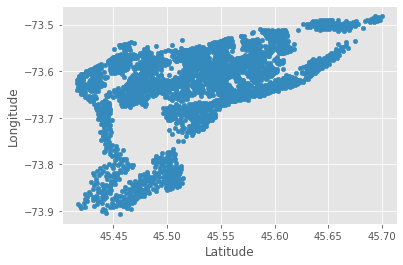

In [7]:
quartier.plot.scatter(x="Latitude", y="Longitude")
plt.show()
# By plotting the latitude and longitude, we notice it indeed looks like the island of Montreal! There are however two big pockets (East end of Montreal and around PET Airport). 

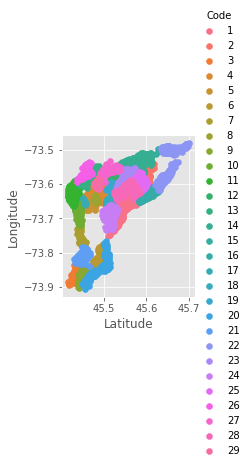

In [8]:
sns.FacetGrid(quartier, 
    hue="Code").map(plt.scatter, "Latitude", "Longitude").add_legend()
plt.show()
# Good news - from the plot below, we see that the neighbourhoods are clustered together in well defined groups!

In [9]:
# Currently, all the data is encoded in a DataFrame, but sklearn doesn't work with pandas' DataFrames, so we need to extract the features and labels and convert them into numpy arrays instead.
labels = np.asarray(quartier.Code)

In [10]:
# Because the Arrondissement's data type is string (and not numeric), we will run into problems when evaluating the model. Luckily, sklearn provides a tool that encodes label-strings as numerical representations. It works by going through an array of labels, and encode the first unique label as 0, then the next unique label as 1 and so on.
#le = LabelEncoder()
#le.fit(labels)

# apply encoding to labels
#labels = le.transform(labels)

In [11]:
# First, we want to remove all the feature columns that we don't want from the DataFrame. Now we only have the columns Latitude and Longitude left.
quartier_selected = quartier.drop(['Code', 'Arrondissement'], axis=1)
print(quartier_selected)

       Latitude  Longitude
0     45.540857 -73.644170
1     45.539566 -73.644945
2     45.538394 -73.645671
3     45.538766 -73.648903
4     45.537107 -73.646482
...         ...        ...
3150  45.484208 -73.610803
3151  45.485861 -73.614297
3152  45.488389 -73.615881
3153  45.483908 -73.587629
3154  45.484064 -73.591321

[3155 rows x 2 columns]


In [12]:
# Since we want to use more than one column, we can't just simply use np.asarray(). Instead, we can use the to_dict() method together with sklearn's DictVectorizer.
quartier_features = quartier_selected.to_dict(orient='records')

In [13]:
# The sklearn interface for using the DictVectorizer class is similar to that of the LabelEncoder. One notable difference is the .toarray() method that is used with fit_transform.
vec = DictVectorizer()
features = vec.fit_transform(quartier_features).toarray()

### 3. Classification model

In [18]:
# Now that we have numerical features and label arrays, there's only one thing left to do: split our data up into a training and a test set.
# Sometimes, with algorithms particularly prone to overfitting, you also have a validation set. We will try with only a training and test set for now.
# Data split (70% training and 30% test). 
# The value of the random_state is not really important as it's just a seed number, but the act of randomizing the data is important, because right now, the data i 
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, 
    test_size=0.30, random_state=0)

### 3.1. Random Forest Classifier

In [19]:
# We will start out with a Random Forest classifier. Random Forests are simple, flexible in that they work well with a wide variety of data, and rarely overfit. One notable downside to Random Forests is that they are non-deterministic in nature, so they don't necessarily produce the same results every time you train them.
# Import
from sklearn.ensemble import RandomForestClassifier

# Initialize
clf = RandomForestClassifier()

# Train the classifier using the training data
clf.fit(features_train, labels_train)

RandomForestClassifier()

In [20]:
# Compute accuracy using training data
acc_train = clf.score(features_train, labels_train)

print ("Train Accuracy:", acc_train)
# Train Accuracy: 100%

Train Accuracy: 1.0


In [21]:
# Compute accuracy using test data
acc_test = clf.score(features_test, labels_test)

print ("Test Accuracy:", acc_test)
# Test Accuracy: 94% - since this is less than the train accuracy, it suggests that the model slightly overfits, but the results are still quite good.

Test Accuracy: 0.9376979936642027


### 4. Prediction on new data

In [22]:
# Test for the BIXI station at the intersection of Milton and Clark
bixi = [45.512520,-73.570620]
print(clf.predict([bixi]))
# Prediction: Neighbourhood 12 i.e. Le Plateau Mont Royal - success!!

[12]


In [23]:
# Test for the BIXI station at the intersection of Milton and Clark
bixi = [45.512520,-73.570620]
print(clf.predict([bixi]))
# Prediction: Neighbourhood 12 i.e. Le Plateau Mont Royal - success!!

[12]


# PART 2: Modeling

In [2]:
# Run this line into anaconda prompt to install XGBOOST: conda install -c anaconda py-xgboost
# XGBOOST stands for extreme gradient boosting. It is a tree based method:
# https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/ 
import xgboost as xgb

# And other stuff
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics


# NOTES:
# It's a stochastic model. It will output a slightly different model every time it is run, even when fed with the same data.
# PARAMETERS:
# 1. n_estimators - the number of trees
# 2. max_depth - the depth of each tree (modest depth is best)
# 3. learning_rate (eta) - the contribution of each tree on the total
# 4. subsample - the percetage of data on which each subtree is trained
# 5. gamma - the loss reduction required to further split a tree. Large gamma = conservative algo.
# 6. colsample_bytree - the amount of features used on each tree

# Handles missing values built-in

# Sources:
# https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/
# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## 2.1. Getting the data ready

In [3]:
# Let's fetch the CSVs
# BIXI data
url_data_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_hourly.csv'
data_hourly = pd.read_csv(url_data_hourly)
data_hourly = data_hourly.set_index(['dateIDh'])
url_data_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_daily.csv'
data_daily = pd.read_csv(url_data_daily)
data_daily = data_daily.set_index(['dateIDd'])
url_data_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/data_monthly.csv'
data_monthly = pd.read_csv(url_data_monthly)
data_monthly = data_monthly.set_index(['dateIDm'])

# Weather data
url_weather_hourly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_hourly.csv'
weather_hourly = pd.read_csv(url_weather_hourly)
weather_hourly = weather_hourly.set_index(['dateIDh'])
url_weather_daily = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_daily.csv'
weather_daily = pd.read_csv(url_weather_daily)
weather_daily = weather_daily.set_index(['dateIDd'])
url_weather_monthly = 'https://raw.githubusercontent.com/gbincoletto/MATH80629A/main/weather_monthly.csv'
weather_monthly = pd.read_csv(url_weather_monthly)
weather_monthly = weather_monthly.set_index(['dateIDm'])

In [4]:
# I'll merge bixi data with weather data so that I have proper food to feed to xgboost
hourly = pd.concat([weather_hourly, data_hourly], axis=1, join="inner")
hourly.to_csv('global_hourly.csv')
daily = pd.concat([weather_daily, data_daily], axis=1, join="inner")
daily.to_csv('global_daily.csv')
monthly = pd.concat([weather_monthly, data_monthly], axis=1, join="inner")
monthly.to_csv('global_monthly.csv')

In [5]:
# I'm only keeping data from 2019 and past for now (training purposes)
hourly_train = hourly[(hourly['Year'] != 2020)]
daily_train = daily[(daily['Year'] != 2020)]
monthly_train = monthly[(monthly['Year'] != 2020)]


## 2.1.1. Preparing model evaluation function

In [6]:
# INSPIRED BY: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def modelfit(alg, X, Y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=Y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, Y,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
        
    #Print model report:
    print("\nModel Report:")
    print("Best number of estimators:", cvresult.shape[0])
    print("RMSE : %.2f" % sqrt(metrics.mean_squared_error(Y.values, dtrain_predictions)))
    print("nRMSE : ", round(sqrt(metrics.mean_squared_error(Y.values, dtrain_predictions))/Y.mean()*100,4), '% - The lower, the better!')
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## 2.2. Hourly XGBOOST Model

### 2.2.1. Weather only

In [7]:
# First, let us use the weather data to predict only hourly traffic
# TEST CV
X = hourly_train.drop(['dateIDd', 'dateIDm', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'Holiday', 'Duration', 'Volume'], axis=1)
Y1 = hourly_train['Volume']
Y2 = hourly_train['Duration']



Model Report:
Best number of estimators: 558
RMSE : 522.86
nRMSE :  56.3862 % - The lower, the better!


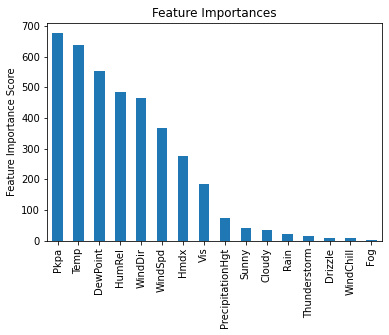

In [8]:
# Define the initial model with near-random parameters. (by near random, I mean that I am choosing them)
# This one predicts volume...
xgb_W1_Y = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 

# Fit for volume
modelfit(xgb_W1_Y,X,Y1)


Model Report:
Best number of estimators: 456
RMSE : 72.42
nRMSE :  9.5866 % - The lower, the better!


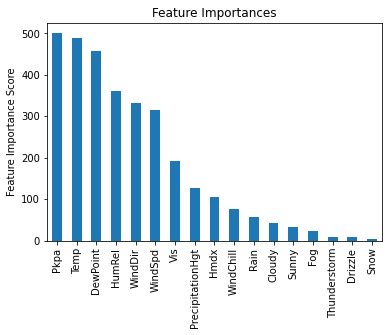

In [9]:
# Fit for duration
modelfit(xgb_W1_Y,X,Y2)

In [ ]:
# Tune-in of parameters from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 
# Step 1: max_depth,min_child_weight


# The paramters we want to test:
param_test1 = {
 'max_depth':range(3,7,2),
 'min_child_weight':range(1,4,2)
}

# Automatic grid search!
gsearch1 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)
gsearch1.fit(X,Y)

# Display results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

In [ ]:
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

In [ ]:
# Update the model with the results from the first grid search
mod2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 
modelfit(mod2,X,Y)

### 2.2.2. Calendar and weather

In [29]:
# SPlITTING DATA
X = hourly_train.drop(['dateIDd', 'dateIDm', 'Duration', 'Volume'], axis=1)
Y1 = hourly_train['Volume']
Y2 = hourly_train['Duration']


Model Report:
Best number of estimators: 5167
RMSE : 92.69
nRMSE :  9.9963 % - The lower, the better!


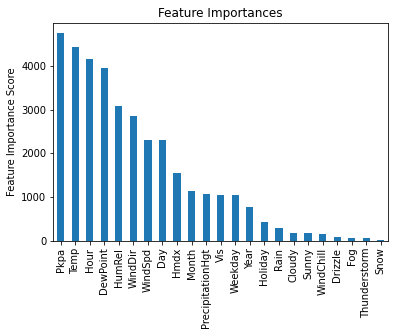

In [30]:
# Basic Model (Weather+Calendar only) for VOLUME
xgb_WC1_Y = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 

# Show fit
modelfit(xgb_WC1_Y,X,Y1)


Model Report:
Best number of estimators: 994
RMSE : 47.90
nRMSE :  6.3413 % - The lower, the better!


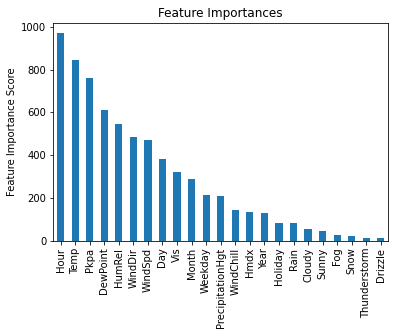

In [31]:
# Show fit for duration
modelfit(xgb_WC1_Y,X,Y2)

VOLUME

In [32]:
# Detailed fit for VOLUME
# Tune-in of parameters from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 
# Step 1: max_depth,min_child_weight

# The parameters we want to test:
param_test1 = {
 'max_depth':range(2,10,2),
 'min_child_weight':range(1,10,3)
}

# Automatic grid search!
gsearch1 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -193.946270 using {'max_depth': 8, 'min_child_weight': 7}
-271.578820 with: {'max_depth': 2, 'min_child_weight': 1}
-270.168204 with: {'max_depth': 2, 'min_child_weight': 4}
-269.650267 with: {'max_depth': 2, 'min_child_weight': 7}
-207.114866 with: {'max_depth': 4, 'min_child_weight': 1}
-210.614586 with: {'max_depth': 4, 'min_child_weight': 4}
-209.268866 with: {'max_depth': 4, 'min_child_weight': 7}
-194.497958 with: {'max_depth': 6, 'min_child_weight': 1}
-195.984876 with: {'max_depth': 6, 'min_child_weight': 4}
-195.513930 with: {'max_depth': 6, 'min_child_weight': 7}
-197.618765 with: {'max_depth': 8, 'min_child_weight': 1}
-194.917401 with: {'max_depth': 8, 'min_child_weight': 4}
-193.946270 with: {'max_depth': 8, 'min_child_weight': 7}


In [36]:
# Additional testing is required:

# The parameters we want to test:
param_test1 = {
 'max_depth':range(8,13,2),
 'min_child_weight':range(4,11,3)
}

# Automatic grid search!
gsearch1 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -193.946270 using {'max_depth': 8, 'min_child_weight': 7}
-194.917401 with: {'max_depth': 8, 'min_child_weight': 4}
-193.946270 with: {'max_depth': 8, 'min_child_weight': 7}
-194.613792 with: {'max_depth': 8, 'min_child_weight': 10}
-204.455753 with: {'max_depth': 10, 'min_child_weight': 4}
-203.841303 with: {'max_depth': 10, 'min_child_weight': 7}
-202.202081 with: {'max_depth': 10, 'min_child_weight': 10}
-216.335630 with: {'max_depth': 12, 'min_child_weight': 4}
-210.334468 with: {'max_depth': 12, 'min_child_weight': 7}
-206.788179 with: {'max_depth': 12, 'min_child_weight': 10}



Model Report:
Best number of estimators: 2223
RMSE : 1.52
nRMSE :  0.164 % - The lower, the better!


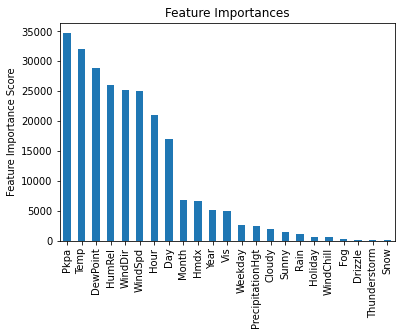

In [34]:
# Update 1 VOLUME 
xgb_WC2_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 
modelfit(xgb_WC2_Y1,X,Y1)

In [39]:
# Step 2: gamma

# The parameters we want to test:
param_test2 = {
 'gamma':[i/10 for i in range(0,11,2)]
}

# Automatic grid search!
gsearch2 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch2.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch2.best_score_, gsearch2.best_params_))
means = gsearch2.cv_results_['mean_test_score']
params = gsearch2.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -193.876874 using {'gamma': 1.0}
-193.918617 with: {'gamma': 0.0}
-193.962339 with: {'gamma': 0.2}
-193.917811 with: {'gamma': 0.4}
-193.908998 with: {'gamma': 0.6}
-193.928721 with: {'gamma': 0.8}
-193.876874 with: {'gamma': 1.0}


In [41]:
# Step 2: gamma - more testing!

# The parameters we want to test:
param_test2 = {
 'gamma':range(2,5)
}

# Automatic grid search!
gsearch2 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch2.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch2.best_score_, gsearch2.best_params_))
means = gsearch2.cv_results_['mean_test_score']
params = gsearch2.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -194.090124 using {'gamma': 4}
-194.124014 with: {'gamma': 2}
-194.095515 with: {'gamma': 3}
-194.090124 with: {'gamma': 4}



Model Report:
Best number of estimators: 2511
RMSE : 1.12
nRMSE :  0.1213 % - The lower, the better!


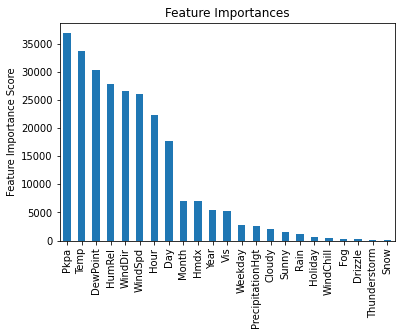

In [43]:
# Update 2 VOLUME 
xgb_WC3_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=4,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 
modelfit(xgb_WC3_Y1,X,Y1)

In [44]:
# Step 3: Subsample & colsample

# The parameters we want to test:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Automatic grid search!
gsearch3 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=4,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch3.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch3.best_score_, gsearch3.best_params_))
means = gsearch3.cv_results_['mean_test_score']
params = gsearch3.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -191.118910 using {'colsample_bytree': 0.9, 'subsample': 0.9}
-201.010345 with: {'colsample_bytree': 0.6, 'subsample': 0.6}
-199.413002 with: {'colsample_bytree': 0.6, 'subsample': 0.7}
-198.930018 with: {'colsample_bytree': 0.6, 'subsample': 0.8}
-197.573478 with: {'colsample_bytree': 0.6, 'subsample': 0.9}
-199.555305 with: {'colsample_bytree': 0.7, 'subsample': 0.6}
-199.383692 with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-197.017568 with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-196.947495 with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-194.504289 with: {'colsample_bytree': 0.8, 'subsample': 0.6}
-195.031769 with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-194.090124 with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-195.216647 with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-193.801556 with: {'colsample_bytree': 0.9, 'subsample': 0.6}
-191.497611 with: {'colsample_bytree': 0.9, 'subsample': 0.7}
-194.777723 with: {'colsample_bytree': 0.9, 'subsample': 0.8}
-1


Model Report:
Best number of estimators: 1394
RMSE : 6.69
nRMSE :  0.7217 % - The lower, the better!


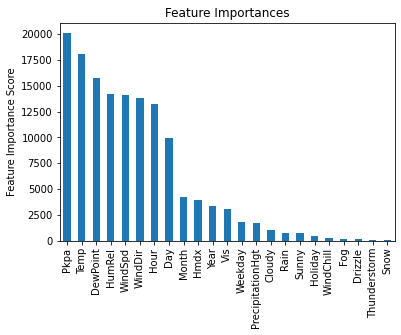

In [47]:
# Update 3 DURATION
xgb_WC4_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=4,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=34
) 
modelfit(xgb_WC4_Y1,X,Y1)

In [50]:
# Step 4: Regularization

# The parameters we want to test:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

# Automatic grid search!
gsearch4 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0,                 
    eta=0.01,
    max_depth=2,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.6,
    random_state=34
), 
 param_grid = param_test4, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch4.fit(X,Y1)

# Display results
print("Best: %f using %s" % (gsearch4.best_score_, gsearch4.best_params_))
means = gsearch4.cv_results_['mean_test_score']
params = gsearch4.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -285.057961 using {'reg_alpha': 0.001}
-285.926990 with: {'reg_alpha': 0}
-285.057961 with: {'reg_alpha': 0.001}
-285.958411 with: {'reg_alpha': 0.005}
-286.077525 with: {'reg_alpha': 0.01}
-285.392836 with: {'reg_alpha': 0.05}



Model Report:
Best number of estimators: 1702
RMSE : 3.94
nRMSE :  0.4245 % - The lower, the better!


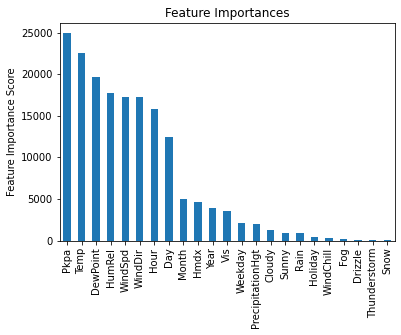

In [52]:
# FINAL MODEL
# Won't decrease learning rate because computational limits
xgb_WC5_Y1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=4,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=7,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha = 0.001,
    random_state=34
) 
modelfit(xgb_WC5_Y1,X,Y1)

DURATION

In [33]:
# Detailed fit for DURATION
# Tune-in of parameters from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 
# Step 1: max_depth,min_child_weight

# The parameters we want to test:
param_test1 = {
 'max_depth':range(2,10,2),
 'min_child_weight':range(1,10,3)
}

# Automatic grid search!
gsearch1 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1.fit(X,Y2)

# Display results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -63.940243 using {'max_depth': 8, 'min_child_weight': 4}
-68.281483 with: {'max_depth': 2, 'min_child_weight': 1}
-67.649746 with: {'max_depth': 2, 'min_child_weight': 4}
-67.330437 with: {'max_depth': 2, 'min_child_weight': 7}
-68.588744 with: {'max_depth': 4, 'min_child_weight': 1}
-68.752710 with: {'max_depth': 4, 'min_child_weight': 4}
-69.002353 with: {'max_depth': 4, 'min_child_weight': 7}
-65.373992 with: {'max_depth': 6, 'min_child_weight': 1}
-65.691409 with: {'max_depth': 6, 'min_child_weight': 4}
-65.530140 with: {'max_depth': 6, 'min_child_weight': 7}
-64.079461 with: {'max_depth': 8, 'min_child_weight': 1}
-63.940243 with: {'max_depth': 8, 'min_child_weight': 4}
-64.422548 with: {'max_depth': 8, 'min_child_weight': 7}


In [40]:
# Additional testing is required:

# The parameters we want to test:
param_test1 = {
 'max_depth':range(8,13,2),
 'min_child_weight':range(4,11,3)
}

# Automatic grid search!
gsearch1 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test1, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch1.fit(X,Y2)

# Display results
print("Best: %f using %s" % (gsearch1.best_score_, gsearch1.best_params_))
means = gsearch1.cv_results_['mean_test_score']
params = gsearch1.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -63.545278 using {'max_depth': 12, 'min_child_weight': 4}
-63.940243 with: {'max_depth': 8, 'min_child_weight': 4}
-64.422548 with: {'max_depth': 8, 'min_child_weight': 7}
-64.843922 with: {'max_depth': 8, 'min_child_weight': 10}
-63.725450 with: {'max_depth': 10, 'min_child_weight': 4}
-64.109978 with: {'max_depth': 10, 'min_child_weight': 7}
-64.565326 with: {'max_depth': 10, 'min_child_weight': 10}
-63.545278 with: {'max_depth': 12, 'min_child_weight': 4}
-63.641867 with: {'max_depth': 12, 'min_child_weight': 7}
-64.112768 with: {'max_depth': 12, 'min_child_weight': 10}



Model Report:
Best number of estimators: 126
RMSE : 36.51
nRMSE :  4.8339 % - The lower, the better!


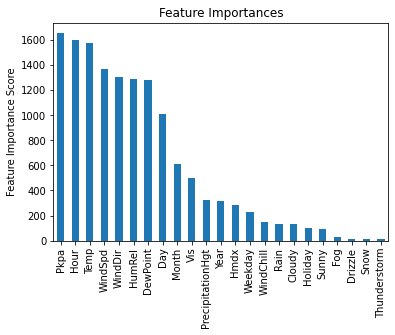

In [35]:
# Update 1 DURATION 
xgb_WC2_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 
modelfit(xgb_WC2_Y2,X,Y2)

In [42]:
# Step 2: gamma

# The parameters we want to test:
param_test2 = {
 'gamma':range(0,5)
}

# Automatic grid search!
gsearch2 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test2, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch2.fit(X,Y2)

# Display results
print("Best: %f using %s" % (gsearch2.best_score_, gsearch2.best_params_))
means = gsearch2.cv_results_['mean_test_score']
params = gsearch2.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -63.809751 using {'gamma': 2}
-63.953343 with: {'gamma': 0}
-63.906707 with: {'gamma': 1}
-63.809751 with: {'gamma': 2}
-63.884591 with: {'gamma': 3}
-64.153606 with: {'gamma': 4}



Model Report:
Best number of estimators: 156
RMSE : 33.40
nRMSE :  4.4213 % - The lower, the better!


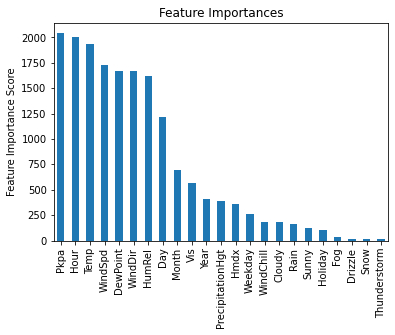

In [45]:
# Update 2 DURATION
xgb_WC3_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=2,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 
modelfit(xgb_WC3_Y2,X,Y2)

In [46]:
# Step 3: Subsample & colsample

# The parameters we want to test:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Automatic grid search!
gsearch3 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=2,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
), 
 param_grid = param_test3, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch3.fit(X,Y2)

# Display results
print("Best: %f using %s" % (gsearch3.best_score_, gsearch3.best_params_))
means = gsearch3.cv_results_['mean_test_score']
params = gsearch3.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -63.488082 using {'colsample_bytree': 0.6, 'subsample': 0.9}
-64.847452 with: {'colsample_bytree': 0.6, 'subsample': 0.6}
-64.540317 with: {'colsample_bytree': 0.6, 'subsample': 0.7}
-63.941641 with: {'colsample_bytree': 0.6, 'subsample': 0.8}
-63.488082 with: {'colsample_bytree': 0.6, 'subsample': 0.9}
-64.833928 with: {'colsample_bytree': 0.7, 'subsample': 0.6}
-64.618317 with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-64.250677 with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-63.836924 with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-65.116522 with: {'colsample_bytree': 0.8, 'subsample': 0.6}
-64.679386 with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-63.809751 with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-63.858023 with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-65.997985 with: {'colsample_bytree': 0.9, 'subsample': 0.6}
-64.995892 with: {'colsample_bytree': 0.9, 'subsample': 0.7}
-64.224528 with: {'colsample_bytree': 0.9, 'subsample': 0.8}
-64.184264 with: {


Model Report:
Best number of estimators: 113
RMSE : 37.22
nRMSE :  4.9275 % - The lower, the better!


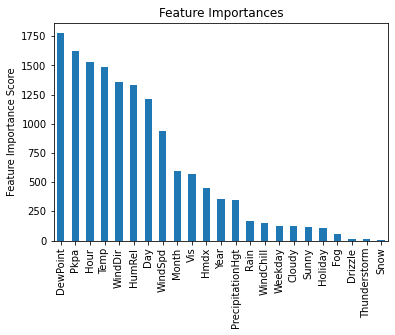

In [49]:
# Update 3 DURATION
xgb_WC4_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=2,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.9,
    colsample_bytree=0.6,
    random_state=34
) 
modelfit(xgb_WC4_Y2,X,Y2)

In [51]:
# Step 4: Regularization

# The parameters we want to test:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

# Automatic grid search!
gsearch4 = GridSearchCV(estimator = XGBRegressor(
    objective='reg:squarederror',
    gamma=2,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.9,
    colsample_bytree=0.6,
    random_state=34
), 
 param_grid = param_test4, scoring='neg_root_mean_squared_error',n_jobs=-1, cv=5)

# Fit
gsearch4.fit(X,Y2)

# Display results
print("Best: %f using %s" % (gsearch4.best_score_, gsearch4.best_params_))
means = gsearch4.cv_results_['mean_test_score']
params = gsearch4.cv_results_['params']
for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))

Best: -63.387168 using {'reg_alpha': 0.01}
-63.488082 with: {'reg_alpha': 0}
-63.626606 with: {'reg_alpha': 0.001}
-63.406717 with: {'reg_alpha': 0.005}
-63.387168 with: {'reg_alpha': 0.01}
-63.531746 with: {'reg_alpha': 0.05}



Model Report:
Best number of estimators: 113
RMSE : 37.54
nRMSE :  4.9701 % - The lower, the better!


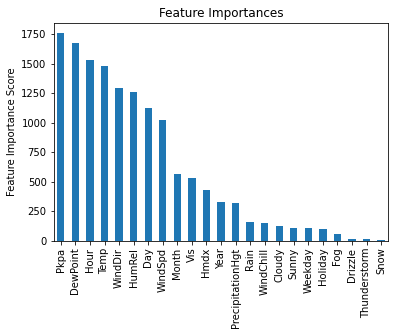

In [53]:
# FINAL MODEL
# Won't decrease learning rate because computational limits
xgb_WC5_Y2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=2,                 
    eta=0.01,
    max_depth=8,
    n_estimators=10000,
    min_child_weight=4,
    subsample=0.9,
    colsample_bytree=0.6,
    reg_alpha=0.01,
    random_state=34
) 
modelfit(xgb_WC5_Y2,X,Y2)

### 2.2.3. Calendar only

In [13]:
# And now we only use ONLY calendar data
X = hourly_train[['Year','Month','Day','Hour','Weekday','Holiday']]
Y1 = hourly_train['Volume']
Y2 = hourly_train['Duration']


Model Report:
Best number of estimators: 4864
RMSE : 241.30
nRMSE :  26.0222 % - The lower, the better!


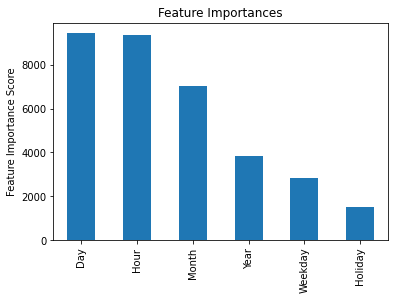

In [14]:
# Basic Model (Calendar only) for VOLUME
xgb_C1_Y = xgb.XGBRegressor(
    objective='reg:squarederror',
    gamma=0.1,                 
    eta=0.01,
    max_depth=3,
    n_estimators=10000,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=34
) 

# Show fit for Volume
modelfit(xgb_C1_Y,X,Y1)


Model Report:
Best number of estimators: 3161
RMSE : 66.37
nRMSE :  8.7868 % - The lower, the better!


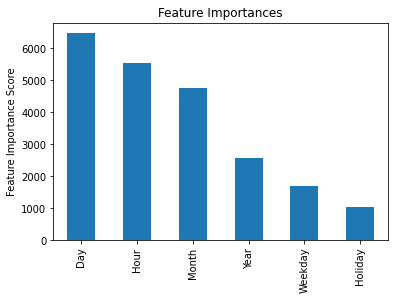

In [15]:
# Show fit for duration
modelfit(xgb_C1_Y,X,Y2)

## 2.3. Daily XGBOOST Model

### 2.3.3. Weather only

In [ ]:
# First, let us use the weather data to predict only daily traffic

# Only the variables explicatives remain in our train df
X_train = daily_train.drop(['dateIDm', 'Year', 'Month', 'Day', 'Weekday', 'Holiday', 'Duration', 'Volume'], axis=1)
X_test = daily_test.drop(['dateIDm', 'Year', 'Month', 'Day', 'Weekday', 'Holiday', 'Duration', 'Volume'], axis=1)
# Only the target remains in our train df
Y_train = daily_train['Volume']
Y_test = daily_test['Volume']


In [ ]:
# Define the Model (Weather only)
mod4 = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=34
) 

mod4.fit(X_train, Y_train)
predictions = mod4.predict(X_test)
rmse = sqrt(mean_squared_error(Y_test, predictions))
print("score: {0:,.0f}".format(rmse))

### 2.3.2. Calendar and weather

In [ ]:
# Let's add the calendar data
X_train = daily_train.drop(['dateIDm', 'Duration', 'Volume'], axis=1)
X_test = daily_test.drop(['dateIDm', 'Duration', 'Volume'], axis=1)
# Only the target remains in our train df
Y_train = daily_train['Volume']
Y_test = daily_test['Volume']

In [ ]:
# Define the Model (Weather+Calendar only)
mod5 = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=34
) 

mod5.fit(X_train, Y_train)
predictions = mod5.predict(X_test)
rmse = sqrt(mean_squared_error(Y_test, predictions))
print("score: {0:,.0f}".format(rmse))

### 2.3.3. Calendar only

In [ ]:
# And now we only use ONLY calendar data
X_train = daily_train[['Year','Month','Day','Weekday','Holiday']]
X_test = daily_test[['Year','Month','Day','Weekday','Holiday']]
# Only the target remains in our train df
Y_train = daily_train['Volume']
Y_test = daily_test['Volume']

In [ ]:
# Define the Model (Calendar only)
mod6 = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=34
) 

mod6.fit(X_train, Y_train)
predictions = mod6.predict(X_test)
rmse = sqrt(mean_squared_error(Y_test, predictions))
print("score: {0:,.0f}".format(rmse))

In [ ]:
print(Y_test.mean())

# ANNEX: Testing the meteostat.net API

In [ ]:
pip install meteostat

In [ ]:
# import all relevant meteostat packages
from datetime import datetime
from meteostat import Stations
from meteostat import Daily
from meteostat import Point

In [ ]:
# check stations available in the montreal area
stations = Stations()
stations = stations.nearby(49.2497, -73.5673)
station = stations.fetch(1)

print(station)

# Remarque: la plupart des stations sont assez éloignées de Montréal.

In [ ]:
# Test pour voir si les données météo concordent avec ce qu'on trouve sur Météomédia malgré tout. Testons juin 2020.
start = datetime(2020, 6, 1)
end = datetime(2020, 6, 30)

data = Daily(station, start=start, end=end)
data = data.normalize()
data = data.fetch()

print(data)
# Conclusion: Il manque beaucoup de données, et celles qu'on a ne sont pas fiables! Nous allons devoir télécharger les données d'Environnement Canada!

In [ ]:
# Je tente d'utiliser le module d'interpolation pour voir si ça donne de meilleurs résultats!
datamtl = Point(49.2497, -73.5673)

start = datetime(2021, 1, 1)
end = datetime(2021, 1, 1)

data = Daily(datamtl, start=start, end=end)
data = data.normalize()
data = data.fetch()

print(data)

# Météomedia donne -0.2 et -5.1, donc meteostat est vraiment dans le champ.

**CONCLUSION:**
Meteostat fonctionne très bien, mais malheureusement les résultats sont très douteux. Je recommande que nous utilisions les données brutes des stations météo d'environnement Canada.

On retrouve les donnnées au: https://climat.meteo.gc.ca/historical_data/search_historic_data_f.html ; il est facile de télécharger les données CSV pour la période qui nous intéresse!